In [1]:
%load_ext autoreload
%autoreload 2
import machine_common_sense as mcs
from jax import numpy as jnp
import jax
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [9]:
controller = mcs.create_controller("sample_config.ini")

In [20]:
scene_data = mcs.load_scene_json_file(f'./ball_scenes/_{i+1:06}.json')
ball_id = scene_data['goal']['metadata']['target']['id']
scene_data

{'goal': {'metadata': {'target': {'id': 'bd57f0dc-ceef-4904-9e1b-f03563543c2f'}},
  'category': 'retrieval',
  'description': 'Find and pick up the small light black white rubber ball.'},
 'holes': [],
 'isometric': False,
 'lava': [],
 'name': '_000006',
 'objects': [{'id': 'bd57f0dc-ceef-4904-9e1b-f03563543c2f',
   'type': 'soccer_ball',
   'mass': 1.8768,
   'salientMaterials': ['rubber'],
   'moveable': True,
   'pickupable': True,
   'shows': [{'position': {'x': -2.2328, 'y': 0.2064, 'z': -3.056},
     'rotation': {'x': 0.0, 'y': 45.0, 'z': 0.0},
     'stepBegin': 0,
     'scale': {'x': 1.8768, 'y': 1.8768, 'z': 1.8768}}],
   'materials': []},
  {'id': 'a893202e-3625-42e0-ad9a-161be266afd3',
   'type': 'chair_6',
   'mass': 8.0,
   'salientMaterials': ['wood'],
   'moveable': True,
   'receptacle': True,
   'shows': [{'position': {'x': -2.7513, 'y': 0, 'z': -2.2446},
     'rotation': {'x': 0.0, 'y': 507.4213, 'z': 0.0},
     'stepBegin': 0,
     'scale': {'x': 1.0, 'y': 1.0, 'z': 

In [5]:
output = controller.start_scene(scene_data)

In [6]:
s = controller.step('RotateRight')

In [30]:
b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
ball_mask_rgb = ball_color
mask = jnp.asarray(s.object_mask_list[-1])

In [6]:
def get_camera_intrinsics(aspect_ratio, field_of_view):
    width, height = aspect_ratio
    aspect_ratio = width / height
    
    cx, cy = width / 2.0, height / 2.0
    
    fov_y = jnp.deg2rad(field_of_view)

    fov_x = 2 * jnp.arctan(aspect_ratio * jnp.tan(fov_y/2.0))
    
    fx = cx / jnp.tan(fov_x / 2.0)
    fy = cy / jnp.tan(fov_y / 2.0)
    
    return cx, cy, fx, fy

def depth_image_to_point_cloud(depth, cx,cy,fx,fy):
    height, width = depth.shape
    xs = (depth * (jnp.arange(width) - cx - 0.5).reshape(1,-1) / fx).reshape(-1)
    ys = (depth * (jnp.arange(height) - cy - 0.5).reshape(-1,1) / fy).reshape(-1)
    zs = depth.reshape(-1)
    
    point_cloud = jnp.stack([xs,ys,zs],axis=0)
    
    return point_cloud
    
def mask_rgb_to_id(mask_rgb):
    r,g,b = mask_rgb
    return jnp.uint32(r+1) + jnp.uint32(g+1) * 256 + jnp.uint32(b+1)*256**2

def get_id_from_masks(ball_color,mask_rgb):
    return jax.lax.cond(jnp.alltrue(ball_color==mask_rgb),lambda: jnp.uint32(0), lambda: mask_rgb_to_id(mask_rgb))

def make_rgb_point_cloud_ball(ball_mask_rgb:jnp.ndarray, mask:jnp.ndarray, rgb:jnp.ndarray, depth:jnp.ndarray, aspect_ratio, field_of_view):
    """computes a flat point cloud (3xN where N is the number of pixels) given a depth map. Also returns the ids, where the ball is always 0 and all others are
    a random number. It also returns a corresponding RGB cloud.
    """
    cx, cy, fx, fy = get_camera_intrinsics(aspect_ratio,field_of_view)
    depth_cloud = depth_image_to_point_cloud(depth, cx, cy, fx, fy)
    rgb_cloud = jnp.stack([rgb[:,:,i].reshape(-1) for i in range(3)],axis=0)
    
    ids = jax.vmap(jax.vmap(get_id_from_masks, in_axes=(None,0)),in_axes=(None,0))(ball_mask_rgb, mask).reshape(-1)
    
    return depth_cloud, rgb_cloud, ids

def voxelize(depth_cloud, rgb_cloud, all_masks, resolution):
    # mask = all_masks == mask_id
    # obj_depths = jnp.round(depth_cloud[:,mask]/resolution)*resolution
    obj_depths = jnp.round(depth_cloud/resolution)*resolution
    _,idxs = jnp.unique(obj_depths, axis=1, return_index=True)
    return obj_depths[:,idxs], rgb_cloud[:,idxs], all_masks[idxs]

d, r, i = jax.jit(make_rgb_point_cloud_ball)(ball_color, mask, jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view)
ball_mask = jax.vmap(jax.vmap(compare_pixels, in_axes=(None,0)),in_axes=(None,0))(ball_mask_rgb, mask)
# plt.imshow(s.object_mask_list[-1])
plt.scatter(d[0],d[1],c=i,s=0.01)

b_d, b_r, b_i = voxelize(d,r,i,0,0.04)
plt.scatter(b_d[0],b_d[1],c=b_i,s=0.01)
plt.show()

NameError: name 'mask' is not defined

In [12]:
jnp.pad(jax.random.normal(jax.random.PRNGKey(0),(3,10)), ((0,0),(0,20)))

DeviceArray([[-0.28371066,  0.9368162 , -1.0050073 ,  1.4165013 ,
               1.0543301 ,  0.9108127 , -0.42656708,  0.986188  ,
              -0.5575324 ,  0.01532502,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ],
             [-2.078568  ,  0.5548371 ,  0.91423655,  0.5744596 ,
               0.7227863 ,  0.12106175, -0.3237354 ,  1.6234998 ,
               0.24500391, -1.3809781 ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.     

In [7]:
MAX_SIZE = 2000
for i in range(100):
    print(i)
    scene_data = mcs.load_scene_json_file(f'./ball_scenes/_{i+1:06}.json')
    ball_id = scene_data['goal']['metadata']['target']['id']
    s = controller.start_scene(scene_data)
    b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
    ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
    d, r, i_ = jax.jit(make_rgb_point_cloud_ball)(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view)
    v_d, v_r, v_m = voxelize(d,r,i_,0.04)
    for id in jnp.unique(v_m):
        idxs = v_m == id
        if idxs.sum()>MAX_SIZE:
            continue
        o_d, o_r = v_d[:,idxs], v_r[:,idxs]
    print(jnp.unique(v_m))


    

0
[  190290   468818  1072459  1260821  9731507 10451661 10539806 10571035
 11583801 12276623 14812329 14982694 16668283]
1
[  205713  7673572  9731507 10451661 10571035 16511481]
2
[  406234  1889346  3042341  5794381  7226271  8012326  8104786  8459502
 10451661 10571035]
3
[       0  1400069  8012326  9434108 10451661 16668283]
4
[       0   409506  3166695  9731507 10329411 10451661 10571035 10876209
 11193034 12044380 12595995 13496740 14869019]
5
[       0  8470400  8815809  9731507 10451661 10571035 14610262]
6


KeyboardInterrupt: 

5


(3, 157)

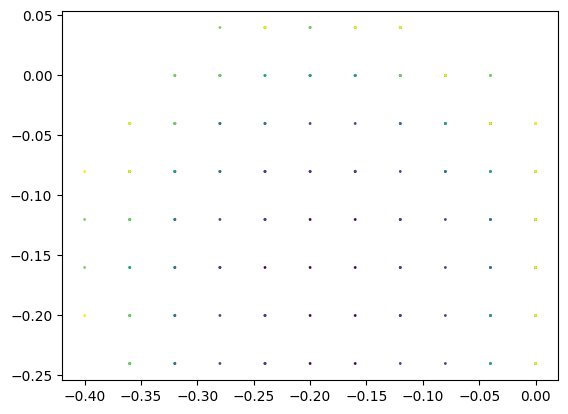

In [16]:
i=5
print(i)
scene_data = mcs.load_scene_json_file(f'./ball_scenes/_{i+1:06}.json')
ball_id = scene_data['goal']['metadata']['target']['id']
s = controller.start_scene(scene_data)
b = [o for o in s.segmentation_colors if o['objectId']==ball_id][0]
ball_color = jnp.array((b['r'],b['g'],b['b']), dtype=jnp.uint8)
d, r, i_ = jax.jit(make_rgb_point_cloud_ball)(ball_color, jnp.asarray(s.object_mask_list[-1]), jnp.asarray(s.image_list[-1]), jnp.asarray(s.depth_map_list[-1]), jnp.array(s.camera_aspect_ratio), s.camera_field_of_view)
v_d, v_r, v_m = voxelize(d,r,i_,0.04)
for id in jnp.unique(v_m):
    idxs = v_m == id
    if idxs.sum()>MAX_SIZE:
        continue
    o_d, o_r = v_d[:,idxs], v_r[:,idxs]

    
idxs = v_m == 0
o_d, o_r = v_d[:,idxs], v_r[:,idxs]
plt.scatter(o_d[0],o_d[1],c=o_d[2],s=1)
o_d.shape

In [ ]:
_